Dans cette partie, nous allons nous occuper de la préparation des données en vue de la création du modèle.

Commençons déjà par importer tous les modules nécessaires 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("/home/onyxia/PY-Music-Genre-Classifier/src/spotify_tracks.csv")

In [3]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


On commence par éliminer toutes les colonnes qui contiennent des noms et des identifiants et qui n'apportent donc aucune information intéressante pour notre étude. 

In [4]:
df.drop(columns=["track_name","track_id","track_artist","track_album_id","track_album_name","track_album_release_date",
       "playlist_name", "playlist_id"], inplace = True)

In [5]:
df.columns

Index(['track_popularity', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

D'abord, on va s'occuper des outliers. On va les identifier avec la méthode du z-score en considérant comme outliers les valeurs ayant un Zscore en valeur absolue supérieur à 3. On peut se permettre cela car les distributions de la plupart des variables sont proches de gaussiennes (voir-ci dessous), même si certaines variables font exception notamment tempo, valence et track_popularity.

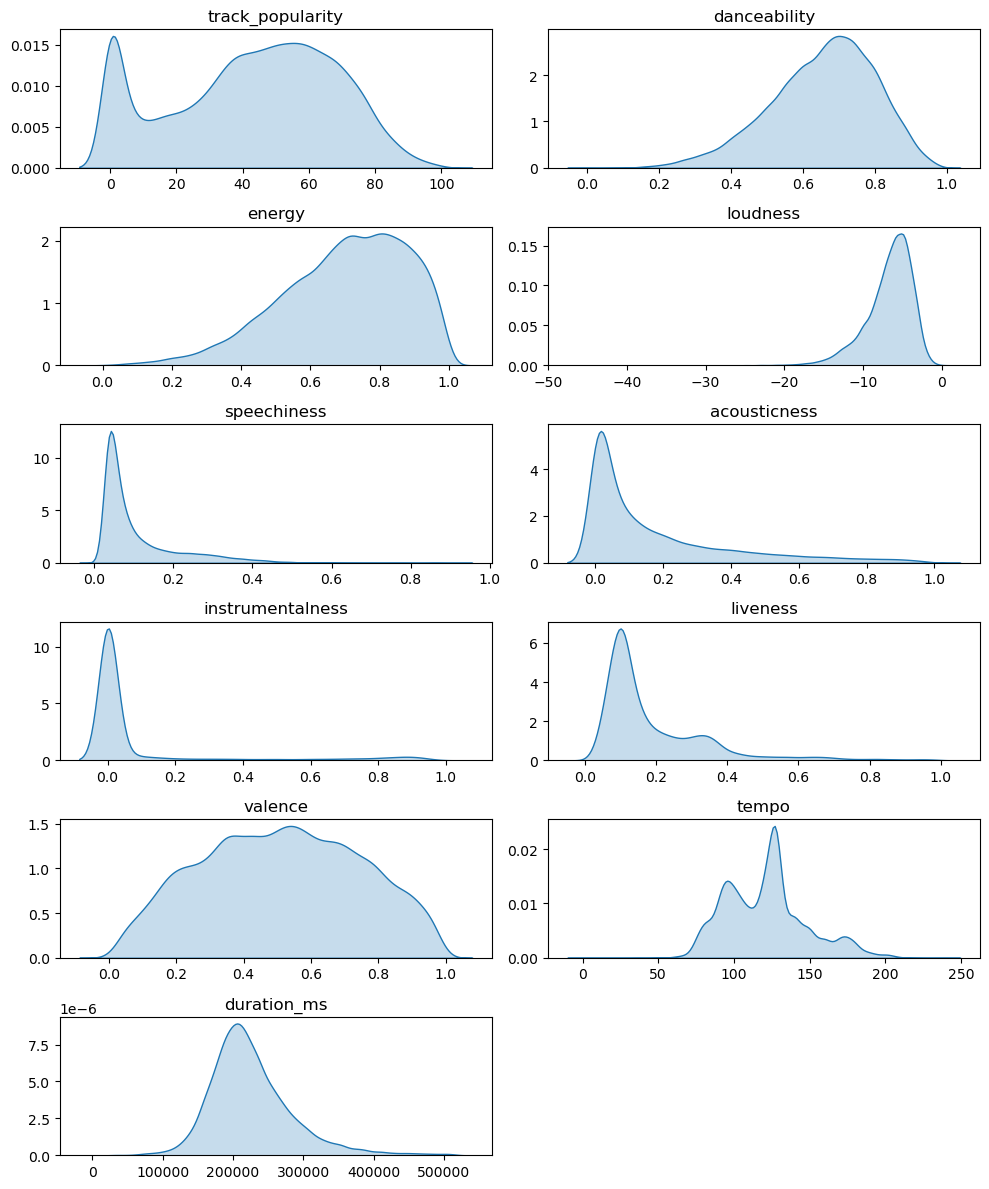

In [6]:
continuous_var = ['track_popularity',
       'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

In [7]:
def count_outliers_zscore(df, threshold=3):
    """
    Compte le nombre d'outliers dans chaque colonne continue d'un DataFrame selon la méthode Z-Score.

    Parameters:
    - df (pd.DataFrame): Le DataFrame contenant les colonnes continues.
    - threshold (float): Seuil pour considérer une valeur comme outlier (par défaut : 3).

    Returns:
    - pd.Series: Série avec le nombre d'outliers pour chaque colonne.
    """
    outlier_counts = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):  # Vérifie que la colonne est numérique
            z_scores = zscore(df[column])
            outliers = np.abs(z_scores) > threshold
            outlier_counts[column] = np.sum(outliers)

    return pd.Series(outlier_counts)

# Compter les outliers
outliers_zscore = count_outliers_zscore(df)

count_outliers_zscore(df)


track_popularity       0
danceability         123
energy               166
key                    0
loudness             368
mode                   0
speechiness          612
acousticness         657
instrumentalness    1692
liveness               0
valence                0
tempo                119
duration_ms          527
dtype: int64

On identifie un petit nombre d'outliers et rien ne nous indique que ces valeurs sont absurdes ou fausses et non juste des valeurs qui sortent un peu de l'ordinaire. Ainsi plutôt que de supprimer les lignes en question, on va plutôt winsorizer les valeurs.

In [8]:
def winsorize_outliers(df, columns, threshold=3):
    """
    Winsorise les valeurs aberrantes (outliers) dans les colonnes continues d'un DataFrame,
    sans modifier le DataFrame original.

    Parameters:
    - df (pd.DataFrame): DataFrame contenant les colonnes continues.
    - columns (list): Liste des colonnes à traiter.
    - threshold (float): Seuil z-score pour définir les outliers.

    Returns:
    - pd.DataFrame: Nouveau DataFrame avec les colonnes ajustées.
    """
    # Créer une copie du DataFrame pour ne pas modifier l'original
    df_copy = df.copy()

    for column in columns:
        z_scores = zscore(df_copy[column])
        
        # Calcul des limites
        lower_bound = df_copy[column][z_scores > -threshold].min()
        upper_bound = df_copy[column][z_scores < threshold].max()
        
        # Winsorisation
        df_copy[column] = np.clip(df_copy[column], lower_bound, upper_bound)
        
    return df_copy

df_winsorized = winsorize_outliers(df, ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo','duration_ms'], 3)

In [9]:
df.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,31028.000000,31849.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.189994,0.510953,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154279,0.232926,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.009360,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [10]:
df_winsorized.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,31028.000000,31849.000000,32833.000000,32833.000000
mean,42.477081,0.654991,0.698879,5.374471,-6.689571,0.565711,0.105772,0.174019,0.079160,0.189994,0.510953,120.867933,225095.928974
std,24.984074,0.144626,0.180072,3.611657,2.860485,0.495671,0.096217,0.215375,0.204893,0.154279,0.232926,26.846991,57203.750865
min,0.000000,0.220000,0.156000,0.000000,-15.682000,0.000000,0.000000,0.000000,0.000000,0.009360,0.000000,46.169000,50705.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.411000,0.833000,0.757000,0.996000,0.991000,201.327000,405291.000000


On remarque ainsi que certaines valeurs extrêmes ont été modifiées, sans que les statistiques les plus basiques (moyenne, variance, médiane et quartiles) ne soient vraiment impactées.

In [11]:
df = df_winsorized

On va désormais s'attaquer à la standardisation des variables continues

In [12]:
columns_to_standardize = ['track_popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms']

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[columns_to_standardize] = scaler.fit_transform(df_standardized[columns_to_standardize])

Vérifions désormais que les colonnes de df_standardized sont bel et bien standardisées, avant de remplacer df par ce nouveau
tableau 

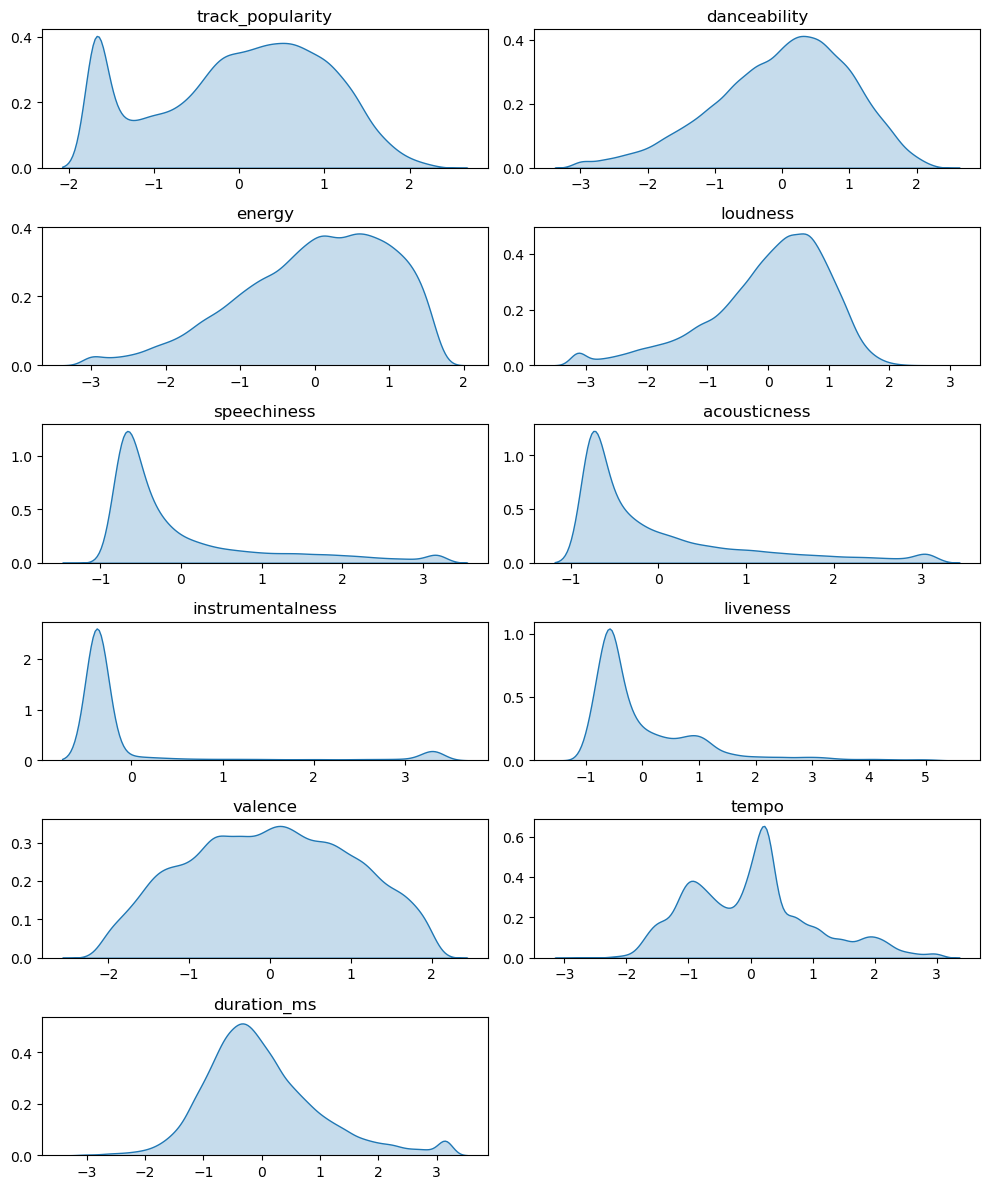

In [13]:
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df_standardized[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")
    
plt.tight_layout()

In [ ]:
# Calculons plutôt la moyenne et la variance des colonnes standardisées
for col in columns_to_standardize:
    mean = df_standardized[col].mean()
    variance = df_standardized[col].var()
    print(f"Variable : {col}")
    print(f"Moyenne : {mean:.6f}")
    print(f"Variance : {variance:.6f}\n")

Variable : track_popularity
Moyenne : -0.000000
Variance : 1.000030

Variable : danceability
Moyenne : 0.000000
Variance : 1.000030

Variable : energy
Moyenne : 0.000000
Variance : 1.000030

Variable : loudness
Moyenne : -0.000000
Variance : 1.000030

Variable : speechiness
Moyenne : 0.000000
Variance : 1.000030

Variable : acousticness
Moyenne : 0.000000
Variance : 1.000030

Variable : instrumentalness
Moyenne : 0.000000
Variance : 1.000030

Variable : liveness
Moyenne : -0.000000
Variance : 1.000032

Variable : valence
Moyenne : -0.000000
Variance : 1.000031

Variable : tempo
Moyenne : -0.000000
Variance : 1.000030

Variable : duration_ms
Moyenne : 0.000000
Variance : 1.000030



Les courbes ont bien changées mais visuellement il est difficile de dire que la standardisation a été correctement effectuée. En revanche, les calculs de moyenne et de variance ne laissent pas de doute. La standardisation est réussie, on peut remplacer df par notre nouveau tableau aux variables continues standardisées.

In [16]:
df = df_standardized

Ainsi toutes nos variables continues sont standardisées, ce qui permettra de rendre les modèles de Machine Learning plus performants. 
Maintenant que cette standardisation a été effectuée, nous allons nous occuper d'imputer les valeurs manquantes.

In [19]:
df.isna().sum()

track_popularity        0
playlist_genre          0
playlist_subgenre       0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness             1805
valence               984
tempo                   0
duration_ms             0
dtype: int64

Nous devons imputer les valeurs manquantes dans 2 colonnes : liveness et valence.Nous allons pour cela comparer 3 modèles, la régression linéaire, random forest et Xgboost. 
Ainsi, pour notre comparaison, pour chaque modèle nous allons faire un test en divisant notre jeu de données, nous permettant de calculer : 
- La MAE (Erreur absolue Moyenne) qui mesure la moyenne des écarts absolus entre les valeurs prédites par le modèle et les valeurs réélles
- Le R2 (Coefficient de détermination) mesurant la proportion de variance des données expliquée par le modèle.
Les résultats vont nous permettre de savoir quel modèle est le plus performants entre les 3. C'est avec ce modèle que nous ferons donc la prédiction des valeurs manquantes dans les colonnes liveness et tempo
Nous allons naïvement utiliser toutes les autres variables (à l'exception de playlist-genre et playlist_subgenre) comme variables prédictives.

In [15]:
predictors = ['track_popularity', 'speechiness', 'instrumentalness', 'energy', 'danceability', 'acousticness', 'tempo', 
              'duration_ms', 'loudness', 'key', 'mode']

In [16]:
def impute_with_linear_regression(df, target_column, predictors, test_size=0.2):
    clean_data = df[df[target_column].notna()]
    X = clean_data[predictors]
    y = clean_data[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE : {mae:.4f}")
    print(f"R^2 : {r2:.4f}")

impute_with_linear_regression(df, 'liveness', predictors)

impute_with_linear_regression(df, 'valence', predictors)

MAE : 0.1088
R^2 : 0.0497
MAE : 0.1691
R^2 : 0.2147


In [20]:
def impute_with_random_forest(df, target_column, predictors, random_state=42):
    """
    Impute les valeurs manquantes d'une colonne avec un Random Forest Regressor.

    Arguments :
    - df : DataFrame pandas
    - target_column : Nom de la colonne cible à imputer
    - predictors : Liste des colonnes à utiliser comme prédicteurs
    - random_state : Seed pour la reproductibilité

    Retourne :
    - DataFrame avec les valeurs imputées pour la colonne cible
    """
    df_rf = df.copy()
    # Séparer les données en deux groupes : avec et sans NaN
    train_data = df_rf[df_rf[target_column].notna()]
    test_data = df_rf[df_rf[target_column].isna()]

    # Si aucune valeur à imputer, on retourne le DataFrame inchangé
    if test_data.empty:
        return df_rf

    # Features (X) et Target (y) pour l'entraînement
    X_train = train_data[predictors]
    y_train = train_data[target_column]

    # Features (X) pour la prédiction
    X_test = test_data[predictors]

    # Modèle Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf_model.fit(X_train, y_train)

    # Prédictions pour les valeurs manquantes
    predicted_values = rf_model.predict(X_test)

    # Remplacement des NaN dans la colonne cible
    df_rf.loc[df[target_column].isna(), target_column] = predicted_values

    return df_rf

# Imputation pour 'liveness'
df_intermediary = impute_with_random_forest(df, target_column='liveness', predictors=predictors)

# Imputation pour 'valence'
df_rf = impute_with_random_forest(df_intermediary, target_column='valence', predictors=predictors)


In [21]:
def test_random_forest_imputation(df, target_column, predictors, missing_rate=0.2, random_state=42):
    """
    Teste la validité de l'imputation avec un Random Forest Regressor.

    Arguments :
    - df : DataFrame pandas original
    - target_column : Nom de la colonne cible
    - predictors : Liste des colonnes à utiliser comme prédicteurs
    - missing_rate : Proportion des données à masquer pour le test
    - random_state : Seed pour la reproductibilité

    Retourne :
    - MAE : Erreur absolue moyenne entre les vraies et les valeurs imputées
    - R^2 : Coefficient de détermination des valeurs imputées
    """
    # Fixer le random seed
    np.random.seed(random_state)

    # Copie du DataFrame pour éviter les modifications
    df_copy = df.copy()

    # Sélectionner les indices à masquer
    non_missing_indices = df_copy[target_column].dropna().index
    n_missing = int(missing_rate * len(non_missing_indices))
    missing_indices = np.random.choice(non_missing_indices, n_missing, replace=False)

    # Masquer les valeurs (création de NaN)
    true_values = df_copy.loc[missing_indices, target_column]
    df_copy.loc[missing_indices, target_column] = np.nan

    # Imputation avec Random Forest
    df_rf = impute_with_random_forest(df_copy, target_column, predictors)

    # Récupérer les valeurs imputées
    imputed_values = df_rf.loc[missing_indices, target_column]

    # Calculer les métriques
    mae = mean_absolute_error(true_values, imputed_values)
    r2 = r2_score(true_values, imputed_values)

    return mae, r2

# Exemple d'utilisation pour 'liveness'
mae_liveness, r2_liveness = test_random_forest_imputation(df, target_column='liveness', predictors=predictors)
print(f"Liveness - MAE : {mae_liveness:.4f}, R^2 : {r2_liveness:.4f}")

# Exemple d'utilisation pour 'valence'
mae_valence, r2_valence = test_random_forest_imputation(df, target_column='valence', predictors=predictors)
print(f"Valence - MAE : {mae_valence:.4f}, R^2 : {r2_valence:.4f}")

Liveness - MAE : 0.0943, R^2 : 0.2077
Valence - MAE : 0.1296, R^2 : 0.4589


In [22]:
df_rf.isna().sum()

track_popularity     0
playlist_genre       0
playlist_subgenre    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
dtype: int64

In [ ]:
def evaluate_xgboost_model(df, model, target_col, predictors):
    """
    Évalue les performances du modèle XGBoost sur une colonne cible.
    Retourne la MAE et le R^2.
    """
    # Séparer les données utilisées pour l'entraînement
    valid_data = df[df[target_col].notna()]
    X = valid_data[predictors]
    y_true = valid_data[target_col]
    
    # Prédictions
    y_pred = model.predict(X)
    
    # Calcul des métriques
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mae, r2

# Évaluer les performances pour 'liveness'
mae_liveness, r2_liveness = evaluate_xgboost_model(df_intermediary_xg, liveness_model, 'liveness', predictors)
print(f"Liveness - MAE: {mae_liveness:.4f}, R^2: {r2_liveness:.4f}")

# Évaluer les performances pour 'valence'
mae_valence, r2_valence = evaluate_xgboost_model(df_xg, valence_model, 'valence', predictors)
print(f"Valence - MAE: {mae_valence:.4f}, R^2: {r2_valence:.4f}")


Liveness - MAE: 0.6455, R^2: 0.0973
Valence - MAE: 0.6489, R^2: 0.3382


En se basant sur le R2 et la MAE c'est avec le random forest que l'on obtient les meilleures résultats c'est à dire les plus petites MAE et les plus grands R2. C'est donc avec ce modèle qu'on va imputer les NaNs.

In [31]:
df = df_rf

On va désormais s'occuper d'encoder les variables discrètes restantes.

In [32]:
categorical_var = ['playlist_genre', 'playlist_subgenre', 'key', 'mode']
df[categorical_var].nunique()

playlist_genre        6
playlist_subgenre    24
key                  12
mode                  2
dtype: int64

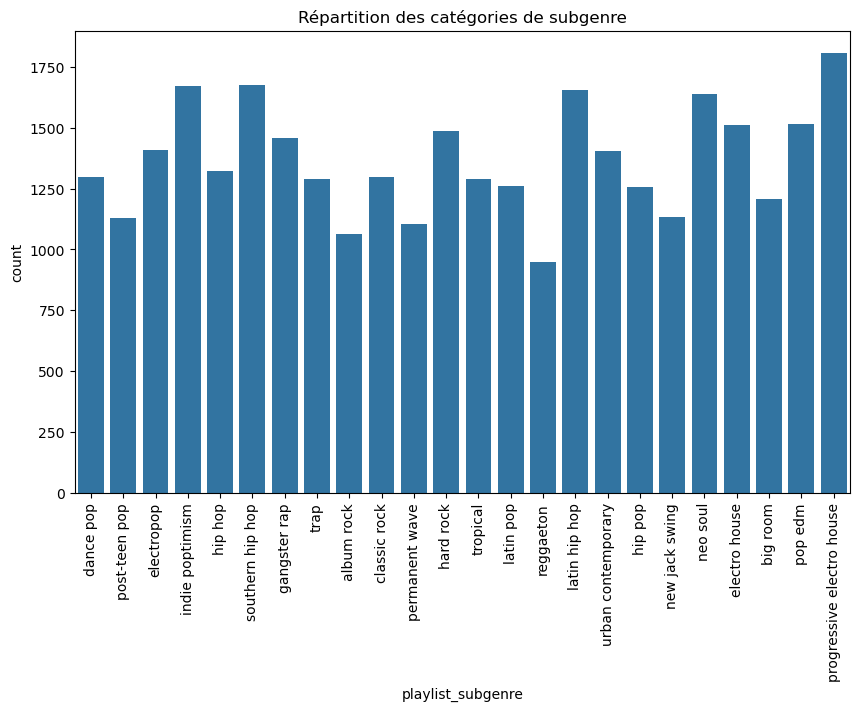

In [ ]:

plt.figure(figsize=(10, 6))
sns.countplot(x='playlist_subgenre', data=df)
plt.title('Répartition des catégories de subgenre')
plt.xticks(rotation=90)  # Rotation des labels si nécessaire
plt.show()

In [34]:
# Afficher les proportions relatives des catégories de 'sub_genre'
print(df['playlist_subgenre'].value_counts(normalize=True))

playlist_subgenre
progressive electro house    0.055097
southern hip hop             0.051016
indie poptimism              0.050924
latin hip hop                0.050437
neo soul                     0.049858
pop edm                      0.046204
electro house                0.046021
hard rock                    0.045229
gangster rap                 0.044407
electropop                   0.042884
urban contemporary           0.042792
hip hop                      0.040264
dance pop                    0.039533
classic rock                 0.039472
trap                         0.039320
tropical                     0.039229
latin pop                    0.038437
hip pop                      0.038254
big room                     0.036731
new jack swing               0.034508
post-teen pop                0.034386
permanent wave               0.033655
album rock                   0.032437
reggaeton                    0.028904
Name: proportion, dtype: float64


In [35]:
df_encoded = df.copy()

# 1. One-Hot Encoding pour 'playlist_genre'
playlist_genre_dummies = pd.get_dummies(df_encoded['playlist_genre'], prefix='playlist_genre')
df_encoded = pd.concat([df_encoded, playlist_genre_dummies], axis=1).drop(columns=['playlist_genre'])

# 2. Encodage Fréquentiel pour 'playlist_subgenre'
subgenre_proportions = df_encoded['playlist_subgenre'].value_counts(normalize=True)
df_encoded['playlist_subgenre_encoded'] = df_encoded['playlist_subgenre'].map(subgenre_proportions)
df_encoded = df_encoded.drop(columns=['playlist_subgenre'])

df_encoded.head()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist_genre_edm,playlist_genre_latin,playlist_genre_pop,playlist_genre_r&b,playlist_genre_rap,playlist_genre_rock,playlist_subgenre_encoded
0,0.941531,0.643106,1.205761,6,1.417813,1,-0.493390,-0.334394,-0.386352,-0.808248,0.030257,0.043509,-0.530427,False,False,True,False,False,False,0.039533
1,0.981557,0.490988,0.644866,11,0.601505,1,-0.711650,-0.471831,-0.365805,1.082508,0.781581,-0.778346,-1.092531,False,False,True,False,False,False,0.039533
2,1.101635,0.138349,1.289062,1,1.138835,0,-0.328136,-0.439329,-0.386238,-0.518509,0.438119,0.116963,-0.847509,False,False,True,False,False,False,0.039533
3,0.701374,0.435672,1.283509,7,1.017875,1,-0.039202,-0.674736,-0.386306,0.090785,-1.004425,0.040529,-0.979023,False,False,True,False,False,False,0.039533
4,1.061609,-0.034513,0.744828,1,0.705335,1,-0.726201,-0.435150,-0.386352,-0.691575,0.918967,0.115771,-0.630107,False,False,True,False,False,False,0.039533


In [36]:
df_encoded.columns

Index(['track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_genre_edm',
       'playlist_genre_latin', 'playlist_genre_pop', 'playlist_genre_r&b',
       'playlist_genre_rap', 'playlist_genre_rock',
       'playlist_subgenre_encoded'],
      dtype='object')

In [37]:
df = df_encoded